In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

note- see issues here with lightgbm install if problems
https://github.com/unit8co/darts/blob/master/INSTALL.md

### Load airpassengers data

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


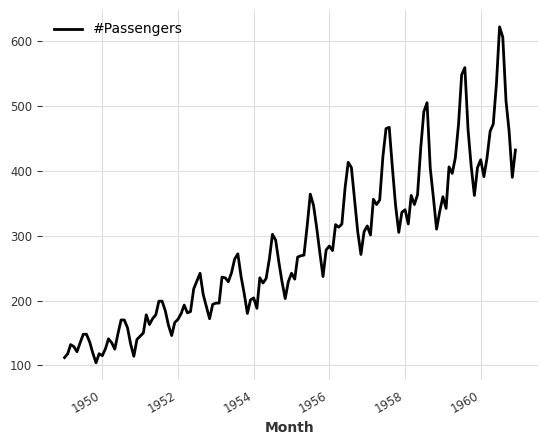

In [2]:
series = AirPassengersDataset().load()
print(series.head(5))
series.plot()

### Some TimeSeries Operations

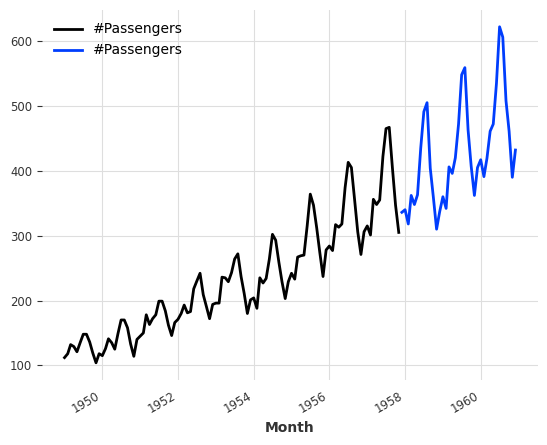

In [3]:
#split
split1, split2 = series.split_before(0.75)
split1.plot()
split2.plot()

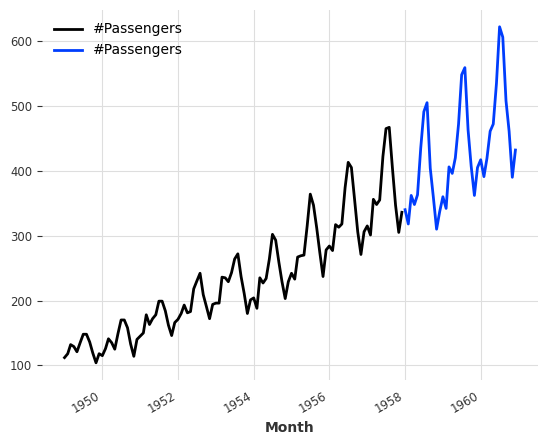

In [4]:
#slice
slice1, slice2 = series[:-36], series[-36:]
slice1.plot()
slice2.plot()

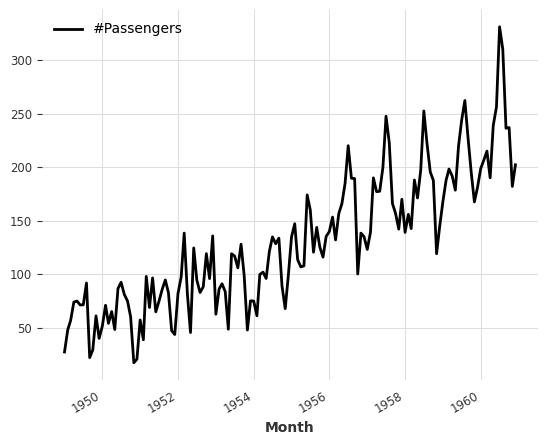

In [5]:
#arithmetic operations
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

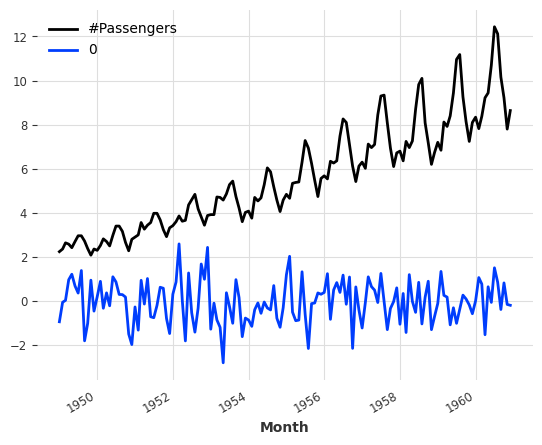

In [6]:
#stacking
(series / 50).stack(series_noise).plot()

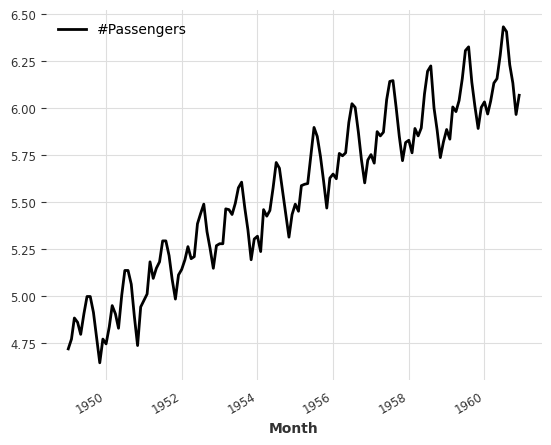

In [7]:
#mapping
series.map(np.log).plot()

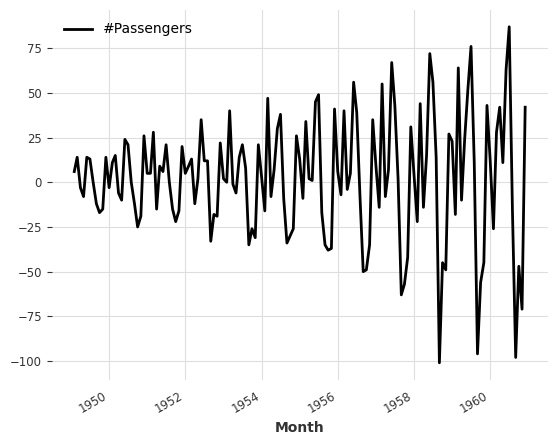

In [8]:
#differencing
series.diff().plot()

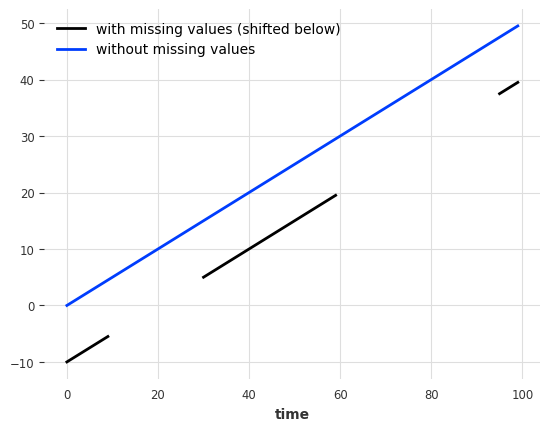

In [9]:
#missing values
from darts.utils.missing_values import fill_missing_values

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

### Creating a training and validation series

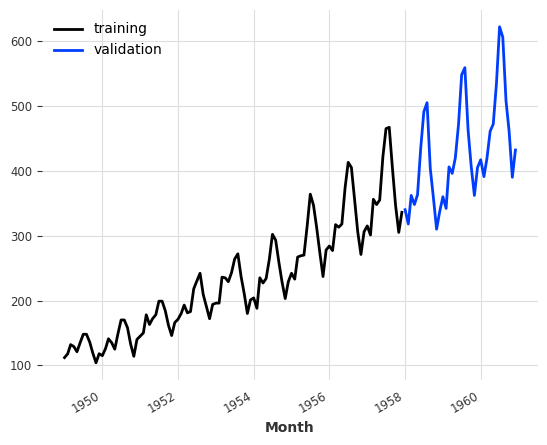

In [10]:
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

### Training forecasting models and making predictions

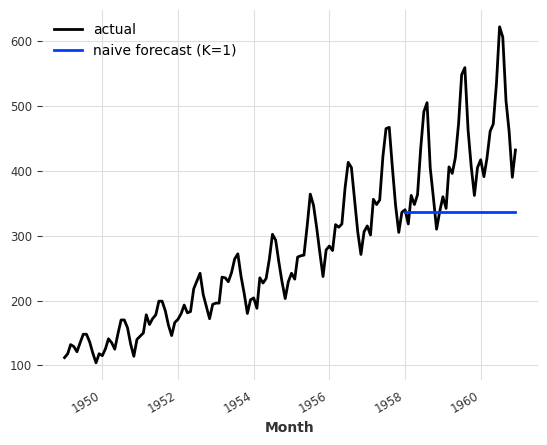

In [11]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

There is seasonality of order 12.


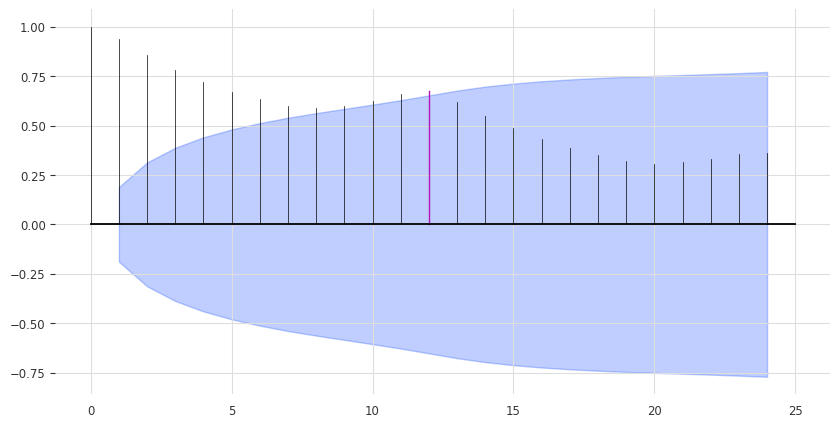

In [13]:
#Inspect Seasonality
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

### A less naive model

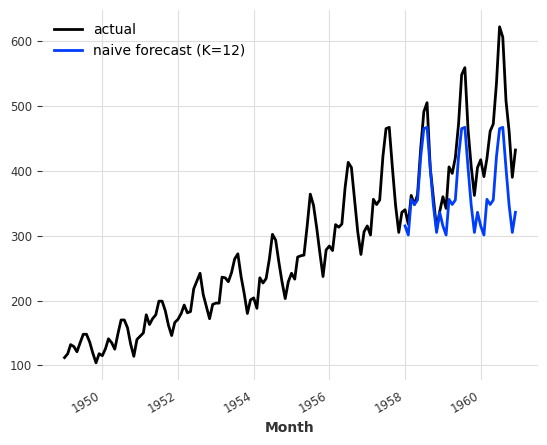

In [14]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

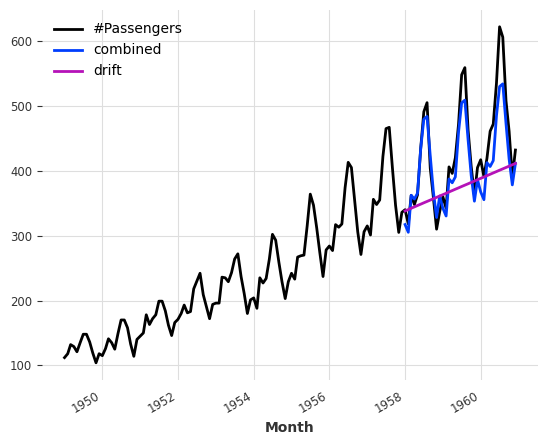

In [15]:
# add in drift/trend
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [47]:
#error metrics
from darts.metrics import mape, r2_score

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    ))
print(
    "Mean absolute percentage error for the combined naive drift + seasonal test: {:.2f}%.".format(
        mape(val, combined_forecast)
    ))


Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.
Mean absolute percentage error for the combined naive drift + seasonal test: 5.66%.


### Quickly try out several models

In [28]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model, plot_flag=0):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))

    if plot_flag:
        series.plot()
        forecast.plot(label=str(model))


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.11%


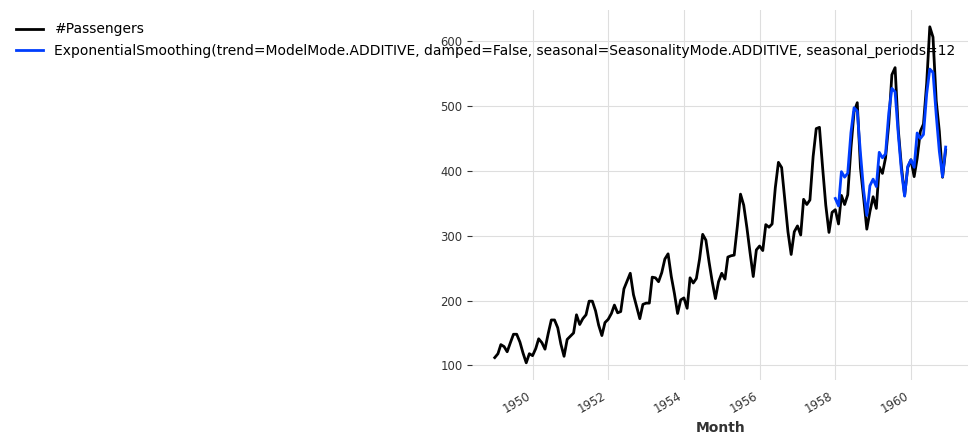

In [29]:
plot_flag=1
eval_model(ExponentialSmoothing(),plot_flag)


model (T)BATS obtains MAPE: 5.87%


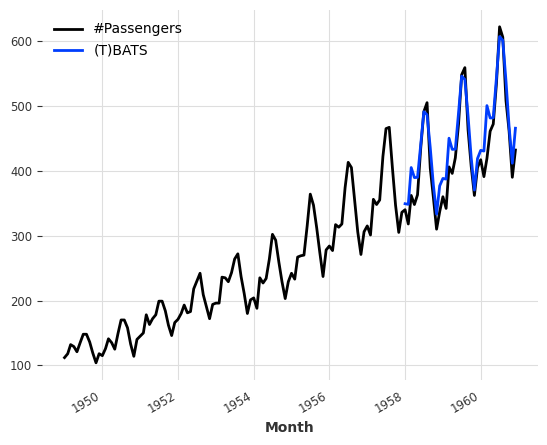

In [30]:
eval_model(TBATS(),plot_flag)


model Auto-ARIMA obtains MAPE: 11.65%


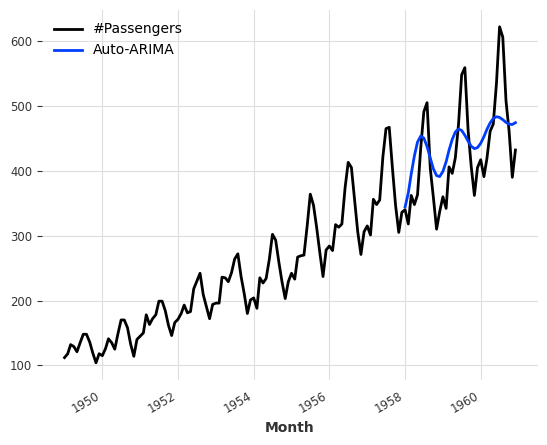

In [31]:
eval_model(AutoARIMA(),plot_flag)


model Theta(2) obtains MAPE: 8.15%


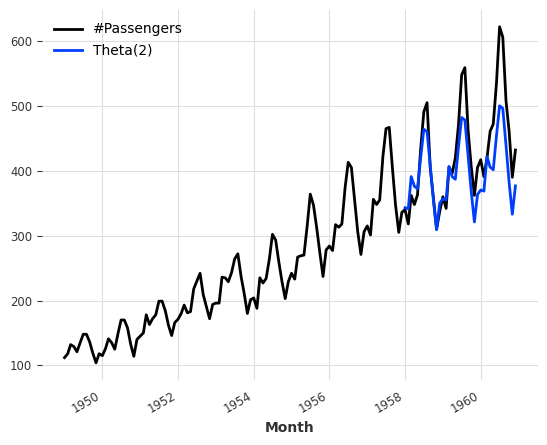

In [32]:
eval_model(Theta(),plot_flag)

### hyper parameter search

In [33]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [34]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


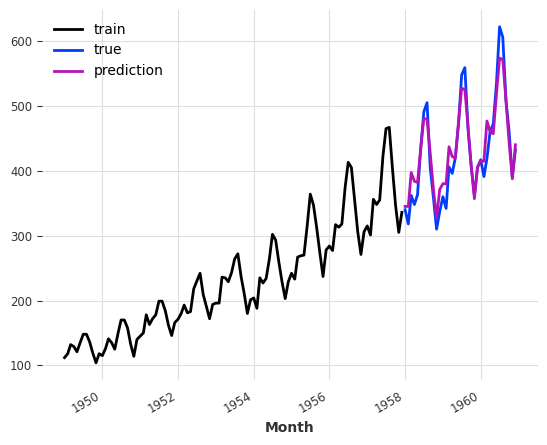

In [35]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

### Backtesting!
3-months ahead forecasts
Looks like historical_forecasts function defined in generic forecasting_model.py
also backtest function ("To have a closer look at the errors, we can also use the backtest() method to obtain all the raw errors (say, MAPE errors) that would have been obtained by our model")

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 7.70%


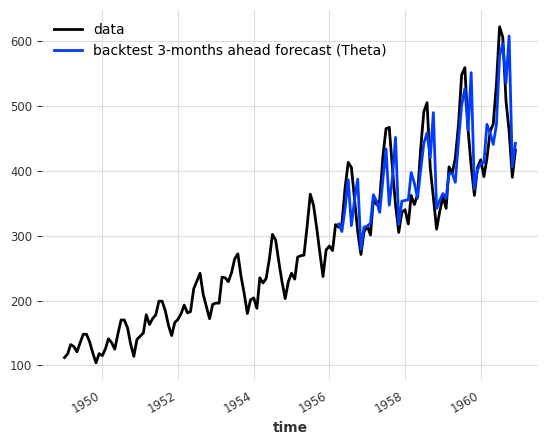

In [36]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/59 [00:00<?, ?it/s]

MAPE = 4.65%


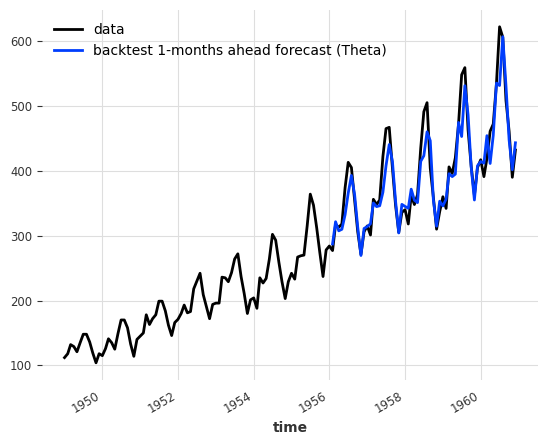

In [44]:
#try 1 month ahead
historical_fcast_theta_1m = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)

series.plot(label="data")
historical_fcast_theta_1m.plot(label="backtest 1-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta_1m, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_theta_1m, series)))

  0%|          | 0/59 [00:00<?, ?it/s]

MAPE = 8.70%


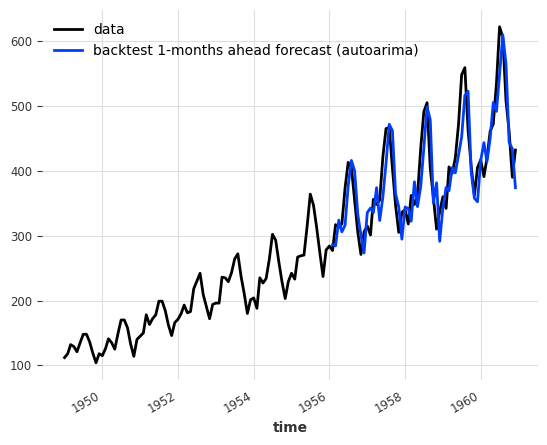

In [45]:
#look at others
model_autoar = AutoARIMA()
historical_fcast_autoarima = model_autoar.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)

series.plot(label="data")
historical_fcast_autoarima.plot(label="backtest 1-months ahead forecast (autoarima)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_autoarima, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_autoarima_1m, series)))

  0%|          | 0/59 [00:00<?, ?it/s]

MAPE = 3.20%


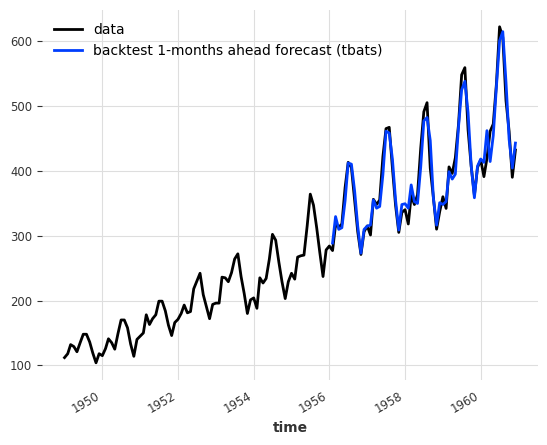

In [46]:
model_tbats = TBATS()
historical_fcast_tbats = model_tbats.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)

series.plot(label="data")
historical_fcast_tbats.plot(label="backtest 1-months ahead forecast (tbats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_tbats, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_tbats, series)))

  0%|          | 0/59 [00:00<?, ?it/s]

MAPE = 3.19%
Rsq = 0.95%


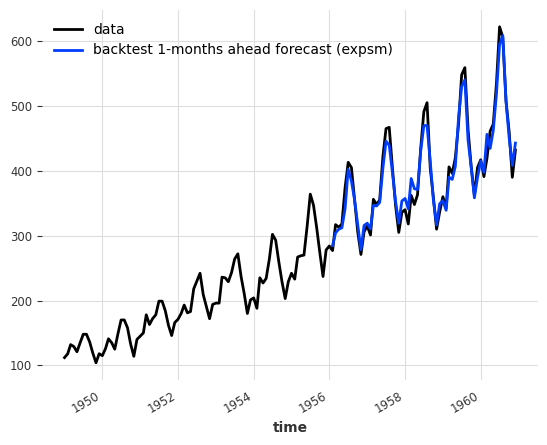

In [83]:
model_expsm = ExponentialSmoothing()
historical_fcast_expsm = model_expsm.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)

series.plot(label="data")
historical_fcast_expsm.plot(label="backtest 1-months ahead forecast (expsm)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_expsm, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_expsm, series)))

  0%|          | 0/59 [00:00<?, ?it/s]

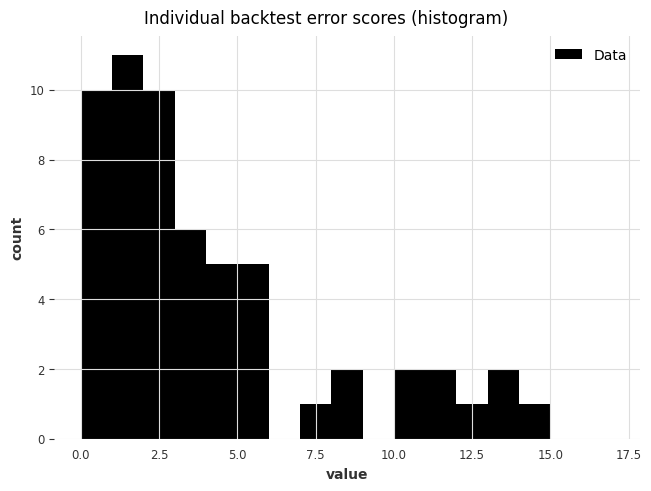

In [50]:
#looking at backtest errors
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=1, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [51]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=1,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/59 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 4.40


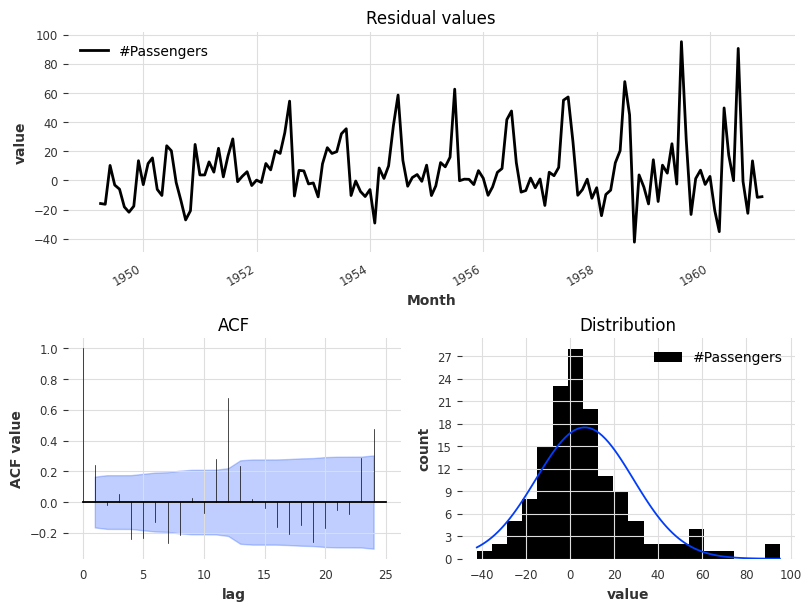

In [52]:
#residuals
# i think this is done on out of sample forecasts but need to double check
# For every index `i` in `series`, `p[i]` is computed by training the model on
#        ``series[:(i - forecast_horizon)]`` and forecasting `forecast_horizon` into the future.
#        (`p[i]` will be set to the last value of the predicted series.)
# and retrain defaults to true

from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

We can see that the distribution is not centered at 0, which means that our Theta model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

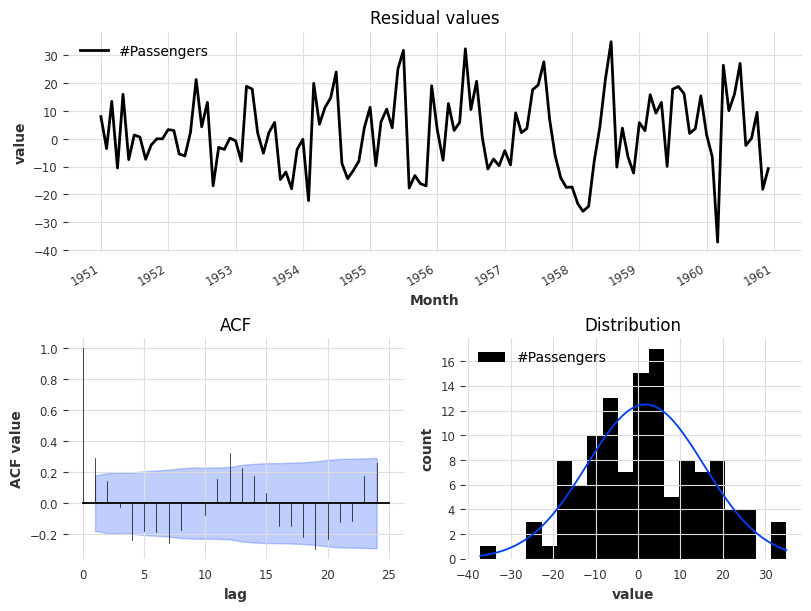

In [55]:
#how about exponential smoothing
plot_residuals_analysis(model_expsm.residuals(series))

### Machine learning and global models
Darts has a rich support for machine learning and deep learning forecasting models; for instance:

RegressionModel can wrap around any sklearn-compatible regression model to produce forecasts (it has its own section below).

RNNModel is a flexible RNN implementation, which can be used like DeepAR.

NBEATSModel implements the N-BEATS model.

TFTModel implements the Temporal Fusion Transformer model.

TCNModel implements temporal convolutional networks.

…

In addition to supporting the same basic fit()/predict() interface as the other models, these models are also global models, as they support being trained on multiple time series (sometimes referred to as meta learning).

This is a key point of using ML-based models for forecasting: more often than not, ML models (especially deep learning models) need to be trained on large amounts of data, which often means a large amount of separate yet related time series.

In Darts, the basic way to specify multiple TimeSeries is using a Sequence of TimeSeries (for instance, a simple list of TimeSeries).

### A toy example with two series

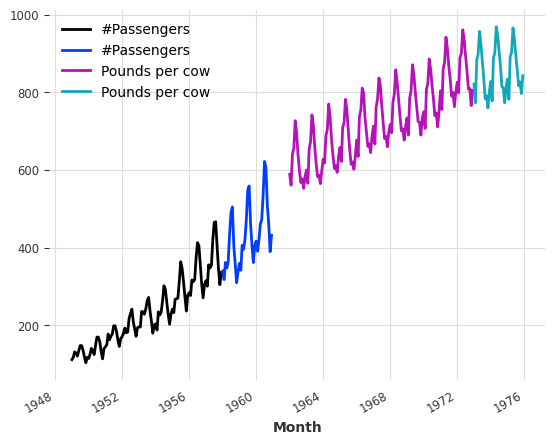

In [56]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

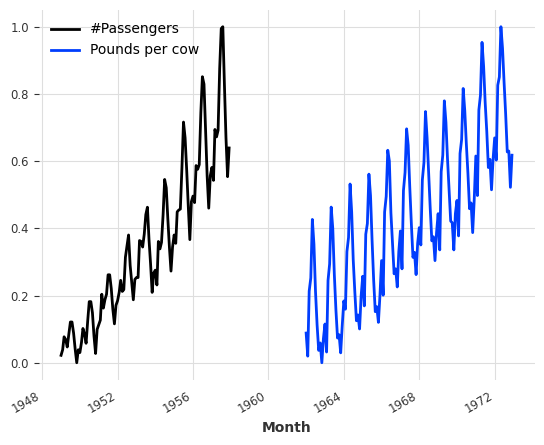

In [57]:
# scaling between 0 and 1 - Note how we can scale several series in one go
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

Using deep learning: example with N-BEATS  
Next, we will build an N-BEATS model. This model can be tuned with many hyper-parameters (such as number of stacks, layers, etc). Here, for simplicity, we will use it with default hyper-parameters. The only two hyper-parameters that we have to provide are:

input_chunk_length: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

output_chunk_length: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

The random_state parameter is just here to get reproducible results.

In [58]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

2022-09-09 14:05:27 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-09 14:05:27 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-09 14:05:27 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-09 14:05:27 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-09 14:05:27 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
2022-09-09 14:05:56 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

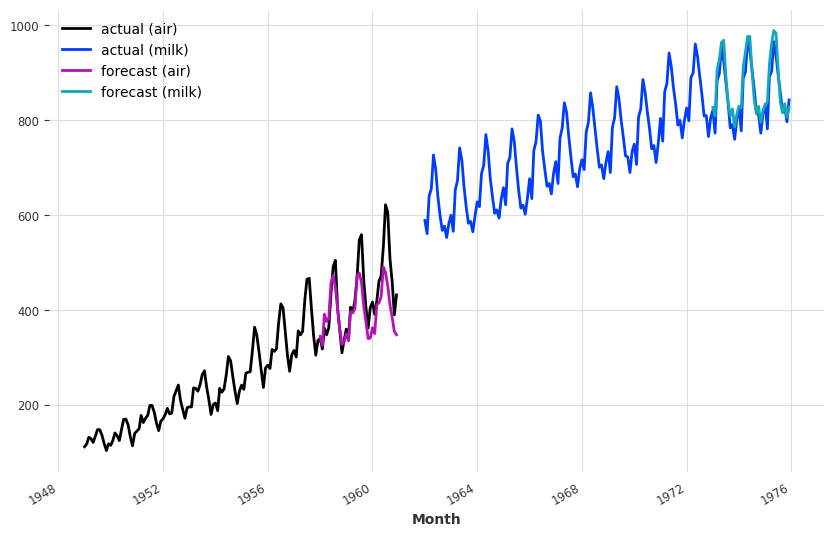

In [59]:
#Let’s now get some forecasts 36 months ahead, for our two series
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [ ]:
model_nbeats = NBEATSModel(input_chunk_length=24, output_chunk_length=1, n_epochs=50, random_state=42)
historical_fcast_nbeats = model_nbeats.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)


MAPE = 2.56%
Rsq = 0.97%


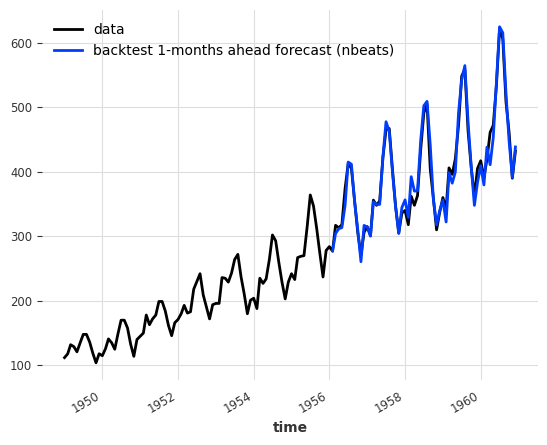

In [73]:
series.plot(label="data")
historical_fcast_nbeats.plot(label="backtest 1-months ahead forecast (nbeats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_nbeats, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_nbeats, series)))

In [ ]:
plot_residuals_analysis(model_nbeats.residuals(series))

### Covariates!
There are two kinds of covariate time series in Darts:

past_covariates are series not necessarily known ahead of the forecast time. Those can for instance represent things that have to be measured and are not known upfront. Models do not use the future values of past_covariates when making forecasts.

future_covariates are series which are known in advance, up to the forecast horizon. This can represent things such as calendar information, holidays, weather forecasts, etc. Models that accept future_covariates will look at the future values (up to the forecast horizon) when making forecasts. 

Each covariate can potentially be multivariate. If you have several covariate series (such as month and year values), you should stack() or concatenate() them to obtain a multivariate series.

The covariates you provide can be longer than necessary. Darts will try to be smart and slice them in the right way for forecasting the target, based on the time indexes of the different series. You will receive an error if your covariates do not have a sufficient time span, though.

Let’s now build some external covariates containing both monthly and yearly values for our air and milk series. In the cell below, we use the darts.utils.timeseries_generation.datetime_attribute_timeseries() function to generate series containing the month and year values, and we concatenate() these series along the "component" axis in order to obtain one covariate series with two components (month and year), per target series. For simplicity, we directly scale the month and year values to have them between (roughly) 0 and 1:



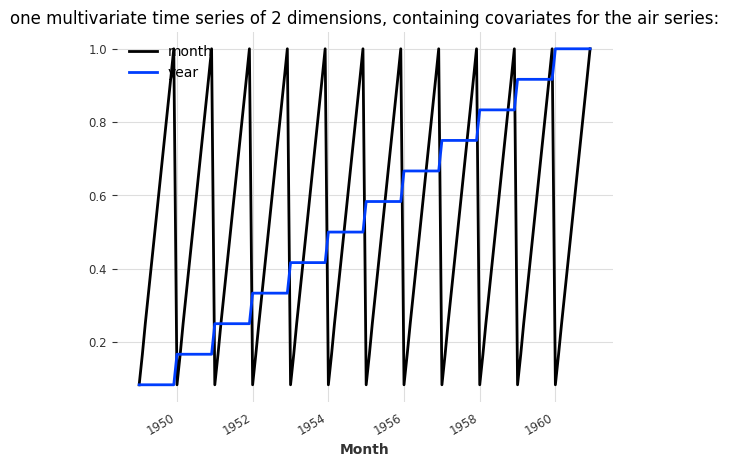

In [65]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [66]:
#nbeats supports only past covariates
model_cov = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model_cov.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

2022-09-09 14:44:55 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-09 14:44:55 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-09 14:44:55 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-09 14:44:55 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-09 14:44:55 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
2022-09-09 14:45:28 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

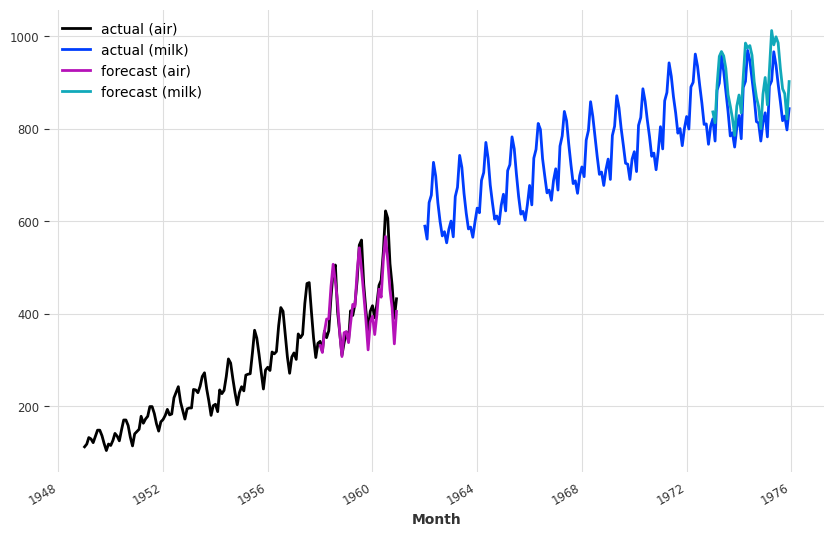

In [68]:
pred_air = model_cov.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model_cov.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

### Encoders: using covariates for free¶

Using covariates related to the calendar or time axis (such as months and years as in our example above) is so frequent that deep learning models in Darts have a built-in functionality to use such covariates out of the box.

To easily integrate such covariates to your model, you can simply specify the add_encoders parameter at model creation. This parameter has to be a dictionary containing informations about what should be encoded as extra covariate

In [69]:
encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [lambda idx: (idx.year - 1950) / 50]},
    "transformer": Scaler(),
}

In the above dictionary, the following things are specified:

The month should be used as a future covariate, with a cyclic (sin/cos) encoding.

The hour and day-of-the-week should be used as future covariates.

The absolute position (time step in the series) should be used as past covariates.

The relative position (w.r.t the forecasting time) should be used as future covariates.

An additional custom function of the year should be used as past covariates.

All the above covariates should be scaled using a Scaler, which will be fit upon calling the model fit() function and used afterwards to transform the covariates.

In [70]:
# replicate previous with encoders
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [71]:
model_enc = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model_enc.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

2022-09-09 14:49:37 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-09 14:49:37 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-09 14:49:37 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-09 14:49:37 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-09 14:49:37 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/piers/gitprojects/explore/explore_timemachines/.venv/lib/python3.9/site-packages/pytorch_lightning/core/module.py:555: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=self.device)
2022-09-09 14:50:10 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Predicting: 7it [00:00, ?it/s]

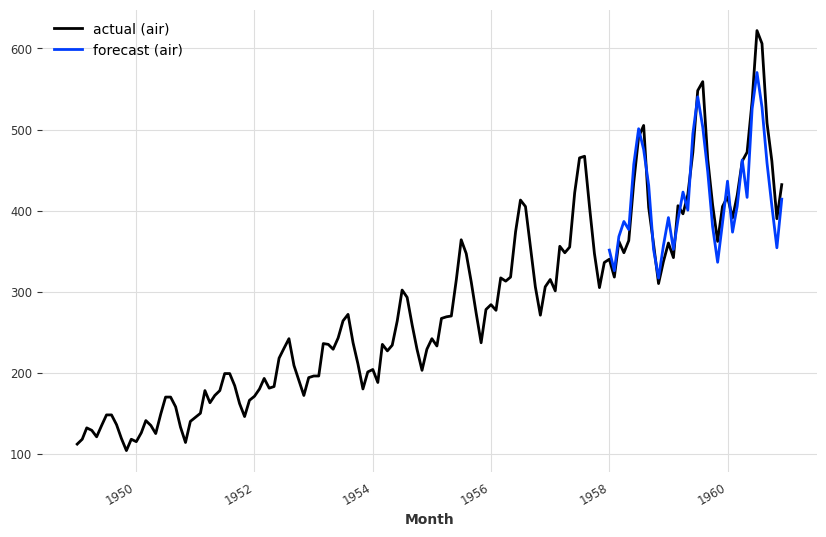

In [75]:
pred_air = model_enc.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [ ]:
#try nbeats with encoders for backtesting
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}
model_nbeats_enc = NBEATSModel(input_chunk_length=24
                               , output_chunk_length=1
                               , add_encoders=encoders
                               , n_epochs=50
                               , random_state=42)
historical_fcast_nbeats_enc = model_nbeats_enc.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)



MAPE = 2.56%
Rsq = 0.97%


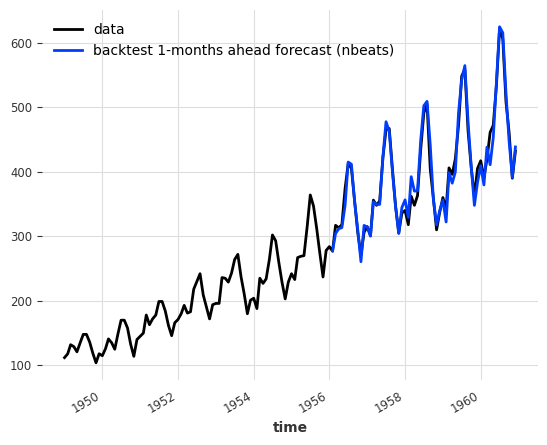

In [78]:
#without covariates
series.plot(label="data")
historical_fcast_nbeats.plot(label="backtest 1-months ahead forecast (nbeats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_nbeats, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_nbeats, series)))

MAPE = 2.73%
Rsq = 0.97%


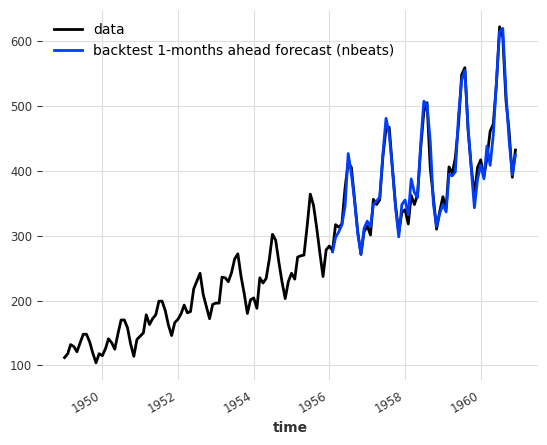

In [79]:
#with covariates
series.plot(label="data")
historical_fcast_nbeats_enc.plot(label="backtest 1-months ahead forecast (nbeats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_nbeats_enc, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_nbeats_enc, series)))

### Regression forecasting models
RegressionModel’s are forecasting models which wrap around sklearn-compatible regression models. The inner regression model is used to predict future values of the target series, as a function of certain lags of the target, past and future covariates. Behind the scenes, the time series are tabularized in order to build a training dataset in the right format.

By default, the RegressionModel will do a linear regression. It is very easy to use any desired sklearn-compatible regression model by specifying the model parameter, but for convenience Darts also provides a couple of ready-made models out of the box:

RandomForest wraps around sklearn.ensemble.RandomForestRegressor.

LightGBMModel wraps around lightbm.

LinearRegressionModel wraps around sklearn.linear_model.LinearRegression (accepting the same kwargs).

In [80]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

lags=72 is telling the RegressionModel to look at the past 72 lags of the target.

In addition, lags_future_covariates=[-6, 0] means that the model will also look at lags of the future_covariates we provide. Here we enumerate the precise lags we want the models to take into account; the “-6th” and the “0th” lags. The “0th” lag means the “current” lag (i.e., at the time step being forecasted); obviously, knowning this lag requires knowing the data in advance (hence the fact we are using future_covariates). Similarly, -6 means we also look at the value of the covariates 6 months before the forecasted time step (which also requires to know the covariates in advance if we are forecasting at a horizon more than 6 steps ahead).

model=BayesianRidge() provides the actual inner regression model.

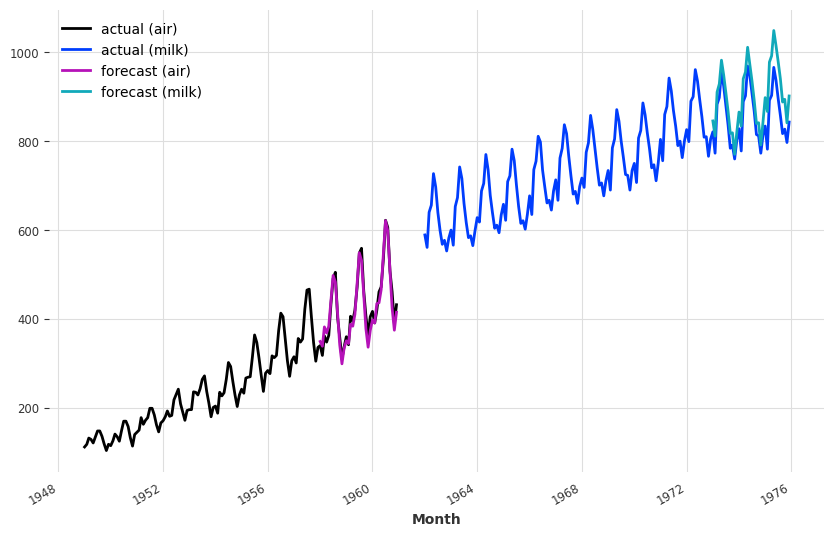

In [81]:
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [ ]:
#try backtest
model_bayesridge = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())
historical_fcast_bayesridge = model_bayesridge.historical_forecasts(
    series, start=0.6, forecast_horizon=1, future_covariates=air_covs, verbose=True
)

MAPE = 2.73%
Rsq = 0.97%


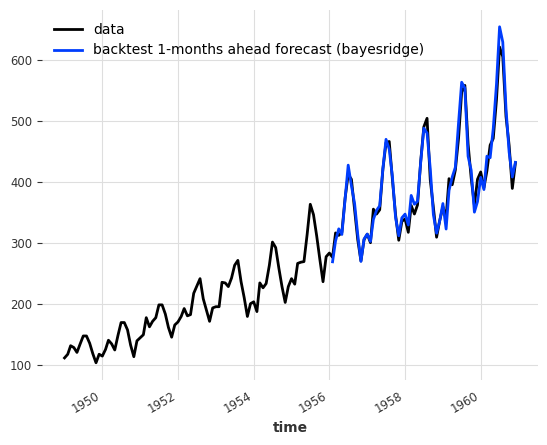

In [88]:
series.plot(label="data")
historical_fcast_bayesridge.plot(label="backtest 1-months ahead forecast (bayesridge)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_bayesridge, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_bayesridge, series)))

In [ ]:
#try backtest

from darts.models import LightGBMModel

model_lgbm_simple = LightGBMModel(lags=24)
historical_fcast_lgbm_simple = model_lgbm_simple.historical_forecasts(
    series, start=0.6, forecast_horizon=1, verbose=True
)

model_lgbm = LightGBMModel(lags=24, lags_future_covariates=[0])
historical_fcast_lgbm = model_lgbm.historical_forecasts(
    series, start=0.6, forecast_horizon=1, future_covariates=air_covs, verbose=True
)

MAPE = 12.61%
Rsq = -0.35%


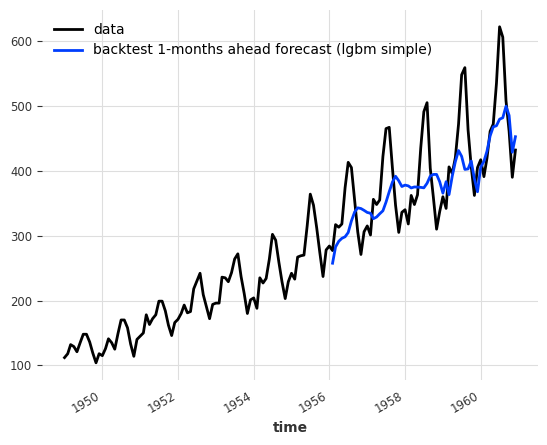

In [102]:
series.plot(label="data")
historical_fcast_lgbm_simple.plot(label="backtest 1-months ahead forecast (lgbm simple)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_lgbm_simple, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_lgbm_simple, series)))

MAPE = 10.78%
Rsq = 0.07%


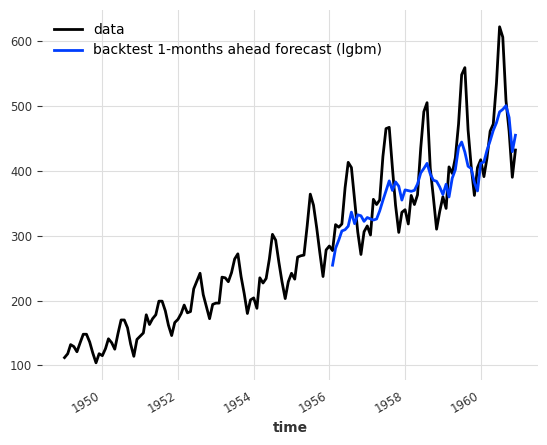

In [103]:
series.plot(label="data")
historical_fcast_lgbm.plot(label="backtest 1-months ahead forecast (lgbm)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_lgbm, series)))
print("Rsq = {:.2f}%".format(r2_score(historical_fcast_lgbm, series)))